In [1]:
# 이미지와 주변 픽셀의 조합을 통해 특징을 추출하는 특징.

In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets 

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cude')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.10.0+cpu  Device: cpu


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
''' 3. CIFAR10 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = '../data/CIFAR_10',
                                train = True,
                                download = True,
                                transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = '../data/CIFAR_10',
                               train = False,
                               transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [5]:
''' 4. 데이터 확인하기 (1) '''
for (x_train, y_train) in train_loader:
    print('x_train:', x_train.size(), 'type:', x_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type()) 
    break

x_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


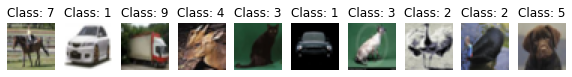

In [6]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(x_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
''' 6. Convolution Neural Network(CNN) 모델 설계하기 '''
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3,
                              out_channels = 8,
                              kernel_size = 3,
                              padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8,
                              out_channels = 16,
                              kernel_size = 3,
                              padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2,
                                stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [8]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

NameError: name 'Net' is not defined

In [9]:
''' 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader): 
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}'.format(Epoch, batch_idx * len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

In [10]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader): # 학습 과정, 완료된 상태에서 MLP 모델의 성능을 평가하는 함수 정의.
    model.eval() # 학습 상태 -> 평가 상태로 지정.
    test_loss = 0 # test_loader 내의 데이터를 이용해 loss를 계산하기 위해 test_loss를 0으로 초기화.
    correct = 0 # 올바른 Class로 분류한 경우를 세기 위해 correct를 0으로 초기화.
    with torch.no_grad(): # torch.no_grad() 메서드를 이용해 gradient의 흐름을 억제.
        for image, label in test_loader: # test_loader: train_loader와 동일한 구성. 순서대로 접근.
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image) # 이미지 데이터를 MLP 모델의 Input으로 이용해 Output을 계산.
            test_loss += criterion(output, label).item() # test_loss: Output - 레이블 => CrossEntropy -> Loss.
            prediction = output.max(1, keepdim = True)[1] # Output: 크기가 10인 벡터 값. 가장 큰 값인 위치로 판단.
            correct += prediction.eq(label.view_as(prediction)).sum().item() # 정답이면 correct에 더해 횟수를 저장.
    test_loss /= len(test_loader.dataset) # test_loss값을 미니배치 개수만큼 나눠 평균 Loss값 계산.
    test_accuracy = 100. * correct / len(test_loader.dataset) # 정확도를 계산.
    return test_loss, test_accuracy

In [ ]:
'''10. MLP 학습을 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    # log_interval: 과정을 모니터링할 수 있도록 출력.
    test_loss, test_accuracy = evaluate(model, test_loader)
    # Loss와 accuracy값을 계산.
    print('\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n'.format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000(0%)]	Train Loss: 2.296242
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 2.109007
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.854502
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 2.074149
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.674949
